In [30]:
#%run '/Users/zhaowenliu/Documents/Tooklits/pyuvvis/examples/Notebooks/NBCONFIG.ipynb'
#%run '/home/glue/Desktop/PYUVVIS/pyuvvis/examples/Notebooks/NBCONFIG.ipynb'
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [31]:
import re
import pyuvvis
import pyuvvis.data
import matplotlib.pyplot as plt

from datetime import datetime
from collections import OrderedDict
from pyuvvis import Spectra


from IPython.html.widgets import (
    FlexBox, VBox, HBox, HTML, Box, RadioButtons,
    FloatText, Dropdown, Checkbox, Image, 
    IntSlider, Button, Text, FloatSlider, IntText, ContainerWidget
)
from IPython.utils.traitlets import (
    link, Unicode, Float, Int, Enum, Bool, Instance, Any
)

Use [`OrderedDict`](https://docs.python.org/2/library/collections.html#collections.OrderedDict) for predictable display of key-value pairs.

In [32]:
%%html
<style>
/*
    This contents of this would go in a separate CSS file.

    Note the namespacing: this is important for two reasons.
    1) doesn't pollute the global namespace
    2) is _more specific_ than the base styles.
*/

.widget-area .spectroscopy .panel-body{
    padding: 0.5;
}
.widget-area .spectroscopy .widget-numeric-text{
    width: 5em;
}
.widget-area .spectroscopy .widget-box.start{
    margin-left: 0;
}
.widget-area .spectroscopy .widget-hslider{
    width: 12em;
}
.widget-area .spectroscopy .widget-text{
    width: 13em;
}
    
</style>

In [33]:
css = """
table
{
  border-collapse: collapse;
}
th
{
  color: #ffffff;
  background-color: #000000;
}
td
{
  background-color: #cccccc;
}
table, th, td
{
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: right;
}
"""


### SPECTROGRAM

In [34]:
from specgui import Box, HTML
from nbtools import mpl2html

from pyuvvis.core.spectra import _normdic as NUdic
import pyuvvis.config as pvconf
from pyuvvis.data import aunps_glass
from pyuvvis.plotting.advanced_plots import PLOTPARSER

class Spectrogram(HTML, Box):
    """
    A notional "complex widget" that knows how to redraw itself when key properties change.
    """

    # CONSTANTS (These are not traits)
    classname = Unicode("btn btn-success",sync=True)
    title = Unicode("Popover Test",sync=True)
    CONTENT = Unicode("""Lovely popover :D. Color in green using class btn btn-success""",sync=True)
    html = Bool(sync=True)
    
    DONT_DRAW = re.compile(r'^(_.+|value|keys|comm|children|visible|parent|log|config|msg_throttle)$')
    NORMUNITS = NUdic
    NORMUNITS_REV = OrderedDict((v,k) for k,v in NORMUNITS.items())
    COLORS = ["b","g","r","y","k"]
    COLORMAPS = sorted(m for m in plt.cm.datad if not m.endswith("_r"))        
    SLIDER_STEPS = Float(25)
    
    # IO traitlets
    load_spec = Bool(False,sync=True)
    load_file = Bool(True,sync=True) #
    file_name = Unicode("", sync=True)
    save_spec = Bool(False,sync=True)
    save_spec_as = Unicode('Test',sync=True)

    # Spectra traits
    spec = Instance(Spectra)
    specname = Unicode('???', sync=True) # What should this be?
    spec_modified = Instance(Spectra)
    
    # Plotting Traits
    figwidth = Float(8)
    figheight = Float(8)
    interactive = Bool(False, sync=True)
    colorbar = Bool(False, sync=True)
    autoupdate = Bool(True, sync=True)
    colormap = Enum(COLORMAPS ,sync=True)
    color = Enum(COLORS, default_value = 'k', sync=True)
    kind = Enum(PLOTPARSER.keys(), default_value = 'spec', sync=True)

    # Units
    spec_unit = Unicode
    var_unit = Unicode 
    iunit = Unicode 
    norm_unit = Enum(NORMUNITS.values(),  sync=True)

    # Message/warnings
    message = Unicode

    
    # Sampling/slicing
    #specslice_axis = Enum([0,1], default_value=0, sync=True)
    specslice_position_start = Float(sync=True)
    specslice_position_end = Float(sync=True)
    specslider_start = Float(sync=True)
    specslider_end = Float(sync=True)
    specstep = Float(sync=True)
    specspacing = Int(1, sync=True)
    
    timeslice_position_start = Float(sync=True)
    timeslice_position_end = Float(sync=True)    
    timeslider_start = Float(sync=True)
    timeslider_end = Float(sync=True)
    timestep = Float(sync=True)
    timespacing = Int(1, sync=True)
    
    selectlines = Bool(False, sync=True)
    
    
    def __init__(self, *args, **kwargs):

        # Initialize traits (_spec_changed calls initial draw)
        super(Spectrogram, self).__init__(*args, **kwargs)
        self._dom_classes += ("col-xs-9",)
        
        
    # DEFAULTS
    # --------
    def _spec_default(self):
        return getattr(pyuvvis.data, 'aunps_water')()

    def _colormap_default(self):
        return pvconf.CMAP_1DSPECPLOT #Use pyuvvis config default (red/blue map)
                
    # Events
    # ------
    def _spec_changed(self, name, old, new):
        """Overall spectrum changes; triggers most events."""

        # Leave this at this position in loop
        self.spec_modified= self.spec
        # --------------

        self._FREEZE = True #pause draws/slicing

        # Units
        self.spec_unit = self.spec.full_specunit
        self.var_unit = self.spec.full_varunit
        self.norm_unit = self.spec.full_norm
        self.iunit = self.spec.full_iunit

                
        # Spec slicing
        print self.spec.index[0], 'specindex 0'
        self.specslice_position_start = self.spec.index[0]
        self.specslice_position_end = self.spec.index[-1]
        print 'changing slice start to', self.spec.index[0]
        self.specslider_start = self.spec.index[0]
        self.specslider_end = self.spec.index[-1]
        self.specstep = (self.spec.index.max() - self.spec.index.min())/self.SLIDER_STEPS
        self.specspacing = 1
        
        self.timeslice_position_start = self.spec.columns[0]
        self.timeslice_position_end = self.spec.columns[-1]
        self.timeslider_start = self.spec.columns[0]
        self.timeslider_end = self.spec.columns[-1]
        self.timestep = (self.spec.columns.max() - self.spec.columns.min())/self.SLIDER_STEPS
        self.timespacing = 1
      
        # Plot defaults to color map
        self._color_state = False
    
        self._FREEZE = False
        self.draw(name, old, new)
        

    def _norm_unit_changed(self, name, old, new):
        self.spec_modified = self.spec_modified.as_norm(self.NORMUNITS_REV[new])
        self.draw(name, old, new)
        
    def _iunit_changed(self, name, old, new):
        self.spec_modified.iunit = new
        # redraw?

    # Plotting events
    # ---------------
       
    def _colormap_changed(self, name, old, new):
        self._color_state = False        
        self.draw(name, old, new)
        
    def _color_changed(self):
        """ Because this sets colorbar, might cause 2 redraws,
        so _FREEZE used to prevent this 
        """
        self._FREEZE = True
        self.colorbar = False
        self._color_state = True
        self._FREEZE = False
        self.draw()
        
    def _colorbar_changed(self, name, old, new):
        self._color_state = False
        self.draw(name, old, new)
        
    def _interactive_changed(self, name, old, new):
        self.var_unit =  '<div class="alert alert-warning"> has been overwritten !</div>'
        self.draw(name, old, new)
        
    # This should be phased out; plots should support colormap, area should handle accordingly
    def _kind_changed(self, name, old, new):
        self.draw(name, old, new)

    def _selectlines_changed(self, name, old, new):
        if self.interactive:
            self.draw(name, old, new)

    # IO Events
    # ---------
    # THIS SHOULD BE LOAD BUTTON CLICKED!!!!
    def _file_name_changed(self):
        try:
            self.spec = getattr(pyuvvis.data, self.file_name)()
        except AttributeError:
            pass
        
    def save_to_ns(self):
        get_ipython().user_ns[self.save_spec_as]=self.spec_modified
        print "SAVED TO: %s" % self.save_spec_as

    
    # Slicing events
    # --------------
    def _specslice_position_start_changed(self, name, old, new):
        self.message = '<div class="alert alert-warning"> BLAH BLAH BLAHY !</div>'

        if not self._FREEZE:
            self.slice_spectrum()
            self.log_and_draw(name, old, new)

    def _specslice_position_end_changed(self, name, old, new):
        if not self._FREEZE:
            self.slice_spectrum()
            self.log_and_draw(name, old, new)

    def _timeslice_position_start_changed(self, name, old, new):
        if not self._FREEZE:
            self.slice_spectrum()
            self.log_and_draw(name, old, new)

    def _timeslice_position_end_changed(self, name, old, new):
        if not self._FREEZE:
            self.slice_spectrum()
            self.log_and_draw(name, old, new)            
            
    def _timespacing_changed(self, name, old, new):
        """ Don't let user set less than 1 or more than dataset size"""
        # Will have to update when add var/spec slicing
        #axis = self.slice_axis
        if self.timespacing < 1:
            self.timespacing = 1
        elif self.timespacing > self.spec_modified.shape[1]:
            self.timespacing = self.spec_modified.shape[1]
            
        self.slice_spectrum()
        self.log_and_draw(name, old, new)            

    def _specspacing_changed(self, name, old, new):
        """ Don't let user set less than 1 or more than dataset size"""
        # Will have to update when add var/spec slicing
        #axis = self.slice_axis
        if self.specspacing < 0:
            self.specspacing = 0
        elif self.specspacing > self.spec_modified.shape[0]:
            self.specspacing = self.spec_modified.shape[0]
            
        self.slice_spectrum()
        self.draw(name, old, new)               
        
            
    # Draw/Slice updates
    # ------------------
    
    def slice_spectrum(self):
        """ Slice and resample spectra """
        self.spec_modified = self.spec.nearby[self.specslice_position_start:self.specslice_position_end:self.specspacing, 
                                              self.timeslice_position_start:self.timeslice_position_end:self.timespacing]
  
    def log_and_draw(self, name=None, old=None, new=None):
        
        self.message = '<div class="alert alert-warning"> Drawing triggered by %s </div>' % name 

        try:
            self.draw(name, old, new)
        except Exception as exc:
            self.message = '<div class="alert alert-danger"> Failed with exception: (%s) </div>' % exc.message 
            raise exc
        else:
            self.message = '<div class="alert alert-success"> Drawing complete </div>' #Add datetime!


    def draw(self, name=None, old=None, new=None):
        if name is not None and self.DONT_DRAW.match(name):
            return
        
        if self._FREEZE:
            return
        
        print 'in draw', name

        plot_and_message = ''

        # Add a header bubble to plot.             
#        if self.save_spec_as is not None:
            #for context in ["alert alert-default","alert alert-info","alert alert-danger","alert alert-warning","alert alert-success"]
#            plot_and_message += '<div class="alert alert-plain"> So for all html objects, popover button or message bar, color follows this match: plain=default,blue=info, red=danger, yellow=warning, green=success </div>' 
#            plot_and_message += '<div class="alert alert-success"> %s has been saved (%s) </div>' %(self.save_spec_as, 
#                                     (datetime.now().isoformat(' ')))
#            plot_and_message += '<div class="alert alert-warning"> %s has been overwritten (%s) !</div>' %(self.save_spec_as, 
#                                     (datetime.now().isoformat(' ')))

            
                        
        # Better way would be a decorator or something that only goes into draw if not autoupdate
        if self.autoupdate:
                        
            # Generate new figure object
            f = plt.figure(figsize=(self.figwidth, self.figheight))
            if PLOTPARSER.is_3d(self.kind):
                projection = '3d'
            else:
                projection = None
            ax = f.add_subplot(111, projection=projection)
            
            if self._color_state or self.kind not in ['spec', 'waterfall', 'contour', 'contour3d']:
                colorkwags = dict(color=self.color)
            else:
                colorkwags = dict(cmap=self.colormap, cbar=self.colorbar)
                
            self.spec_modified.plot(ax=ax, 
                  fig=f, 
                  kind=self.kind, 
                  norm=self.NORMUNITS_REV[self.norm_unit],
                  **colorkwags
                    )
            f.tight_layout() #Padding around plot
            lines = ax.get_lines()
            plt.close(f)

            #http://mpld3.github.io/modules/API.html
            if self.interactive:
                import mpld3
                if self.selectlines:
                    from line_plugin import HighlightLines
            
                    for idx, col in enumerate(self.spec_modified.columns):
                        name = 'COLUMN(%s): %s' % (idx, col)
                        tooltip = mpld3.plugins.LineLabelTooltip(lines[idx], name)
                                                         #voffset=10, hoffset=10,  css=css)
                        mpld3.plugins.connect(f, tooltip)

                    mpld3.plugins.connect(f, HighlightLines(lines))
                    
                plot_and_message += mpld3.fig_to_html(f)
            else:
                plot_and_message += mpl2html(f)

            self.fig_old = f
                
        else:
            plot_and_message += html_figure(self.fig_old)

        # VALUE IS WHAT GUI LOOKS UP!!!
        self.value = plot_and_message

### RUN IT

430.1 specindex 0
changing slice start to 430.1
in draw spec


in draw specslice_position_end


in draw specslice_position_end


in draw specslice_position_end


in draw specslice_position_start


TypeError: Empty 'DataFrame': no numeric data to plot

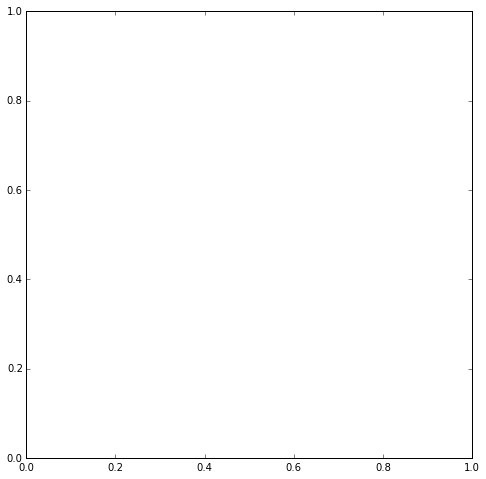

in draw specslice_position_start


TypeError: Empty 'DataFrame': no numeric data to plot

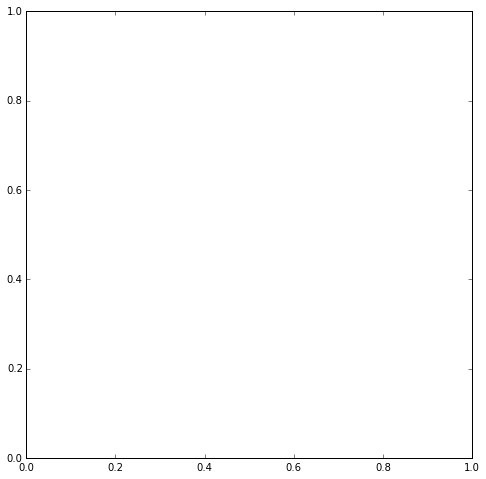

in draw specslice_position_start


TypeError: Empty 'DataFrame': no numeric data to plot

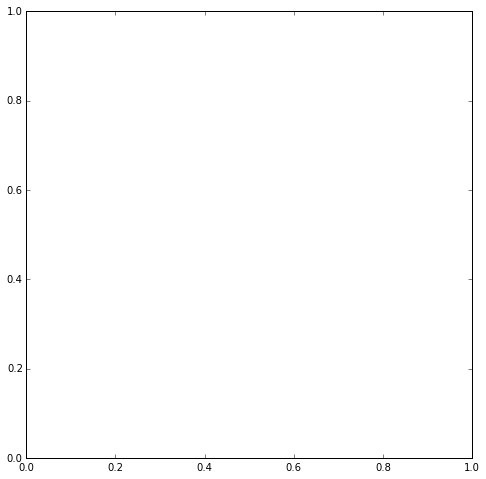

in draw specslice_position_start


TypeError: Empty 'DataFrame': no numeric data to plot

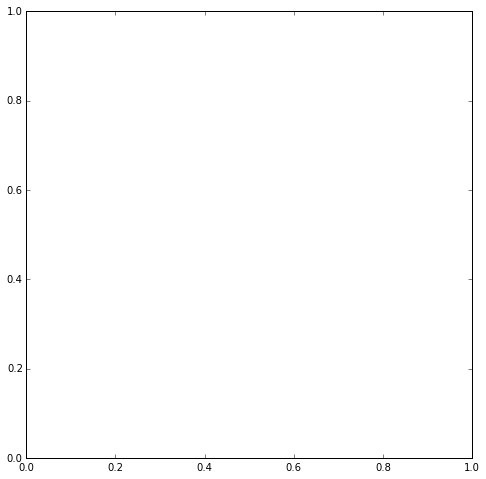

In [35]:
from pyuvvis.data import trip_peaks, aunps_glass
from specgui import SpectralGUI

testspectra = aunps_glass().as_varunit('s')
testspectra.reference = 0

specmodel = Spectrogram(spec=testspectra) #I can initialize/set traits here
#specmodel.spacing = 10

gui = SpectralGUI(model=specmodel)
gui


In [36]:
testspectra.apply(lambda x: x**2, axis=1)

,0.0,3.0,7.0,11.0,14.0,18.0,22.0,25.0,29.0,33.0,...,329.0,333.0,336.0,340.0,344.0,347.0,351.0,355.0,359.0,362.0
430.10,66211.315295,66286.834826,66160.424863,66401.325955,66262.817599,66457.136005,66353.309197,66396.563415,66490.377114,66311.643845,...,4312.728231,4324.256570,4199.035753,4174.089655,4181.452856,4175.745180,4289.359248,4311.613481,4424.884255,4508.765693
430.47,71704.233879,71729.246985,71667.333811,71826.904466,71757.830022,71933.223547,71873.437541,71934.549510,71957.053712,71846.170505,...,4666.500940,4674.383226,4533.367703,4506.131426,4524.532309,4506.504129,4623.137950,4648.991910,4779.012677,4863.367565
430.85,77672.214990,77675.949056,77683.968997,77788.731781,77750.302474,77871.471740,77881.794589,77833.777822,77868.334092,77875.750574,...,5011.539879,5009.787587,4862.359053,4832.789680,4847.661031,4826.221064,4939.859583,4976.480286,5119.548401,5211.160510
431.22,84267.251564,84300.171750,84227.244758,84394.424525,84348.586366,84521.307818,84468.096661,84458.775619,84494.758159,84543.213169,...,5412.935869,5416.994508,5263.638704,5222.779212,5230.997627,5218.834828,5326.751213,5375.061584,5520.730661,5633.834559
431.59,91572.260939,91588.417975,91578.966579,91668.495935,91681.269122,91861.345947,91811.917284,91759.789662,91815.459990,91769.034349,...,5894.106396,5886.052901,5723.113081,5686.566746,5678.545652,5674.909953,5796.546875,5839.321061,6000.395441,6113.579091
431.96,98910.223018,98983.636540,98998.979682,99029.121206,99124.237116,99191.769625,99272.678733,99218.478058,99232.244521,99196.607503,...,6343.088768,6325.179537,6157.788952,6108.963343,6113.146765,6101.561547,6227.658964,6279.942672,6454.968626,6567.463020
432.33,107400.939064,107490.550735,107539.329258,107537.953095,107630.506874,107746.835355,107778.610899,107761.528488,107795.557759,107725.621701,...,6866.432095,6827.944761,6653.975108,6598.375816,6612.471482,6593.925195,6731.542666,6771.105642,6952.794617,7086.338241
432.70,115934.592776,116116.274682,116064.743996,116056.505662,116186.736459,116293.966946,116320.140815,116281.937581,116337.733880,116299.211584,...,7384.714909,7315.682010,7140.625589,7078.011181,7099.342142,7083.491752,7227.795080,7268.818651,7455.289661,7600.508763
433.08,126374.977211,126607.353506,126567.774027,126594.753862,126730.765285,126700.344292,126912.827775,126794.577093,126931.191015,126848.244965,...,8002.161639,7916.043833,7747.969659,7688.038581,7710.261844,7686.728587,7826.394802,7886.865005,8070.261719,8255.796946
433.45,136680.642189,136974.111125,137014.363746,136864.805376,137102.477002,137078.250022,137299.242805,137183.659506,137296.096094,137120.978325,...,8620.236536,8532.684938,8345.347390,8279.542339,8300.774475,8278.176523,8426.757999,8484.005656,8681.624481,8887.195252


In [37]:
eval('testspectra.apply(lambda x: x**2, axis=1)')

,0.0,3.0,7.0,11.0,14.0,18.0,22.0,25.0,29.0,33.0,...,329.0,333.0,336.0,340.0,344.0,347.0,351.0,355.0,359.0,362.0
430.10,66211.315295,66286.834826,66160.424863,66401.325955,66262.817599,66457.136005,66353.309197,66396.563415,66490.377114,66311.643845,...,4312.728231,4324.256570,4199.035753,4174.089655,4181.452856,4175.745180,4289.359248,4311.613481,4424.884255,4508.765693
430.47,71704.233879,71729.246985,71667.333811,71826.904466,71757.830022,71933.223547,71873.437541,71934.549510,71957.053712,71846.170505,...,4666.500940,4674.383226,4533.367703,4506.131426,4524.532309,4506.504129,4623.137950,4648.991910,4779.012677,4863.367565
430.85,77672.214990,77675.949056,77683.968997,77788.731781,77750.302474,77871.471740,77881.794589,77833.777822,77868.334092,77875.750574,...,5011.539879,5009.787587,4862.359053,4832.789680,4847.661031,4826.221064,4939.859583,4976.480286,5119.548401,5211.160510
431.22,84267.251564,84300.171750,84227.244758,84394.424525,84348.586366,84521.307818,84468.096661,84458.775619,84494.758159,84543.213169,...,5412.935869,5416.994508,5263.638704,5222.779212,5230.997627,5218.834828,5326.751213,5375.061584,5520.730661,5633.834559
431.59,91572.260939,91588.417975,91578.966579,91668.495935,91681.269122,91861.345947,91811.917284,91759.789662,91815.459990,91769.034349,...,5894.106396,5886.052901,5723.113081,5686.566746,5678.545652,5674.909953,5796.546875,5839.321061,6000.395441,6113.579091
431.96,98910.223018,98983.636540,98998.979682,99029.121206,99124.237116,99191.769625,99272.678733,99218.478058,99232.244521,99196.607503,...,6343.088768,6325.179537,6157.788952,6108.963343,6113.146765,6101.561547,6227.658964,6279.942672,6454.968626,6567.463020
432.33,107400.939064,107490.550735,107539.329258,107537.953095,107630.506874,107746.835355,107778.610899,107761.528488,107795.557759,107725.621701,...,6866.432095,6827.944761,6653.975108,6598.375816,6612.471482,6593.925195,6731.542666,6771.105642,6952.794617,7086.338241
432.70,115934.592776,116116.274682,116064.743996,116056.505662,116186.736459,116293.966946,116320.140815,116281.937581,116337.733880,116299.211584,...,7384.714909,7315.682010,7140.625589,7078.011181,7099.342142,7083.491752,7227.795080,7268.818651,7455.289661,7600.508763
433.08,126374.977211,126607.353506,126567.774027,126594.753862,126730.765285,126700.344292,126912.827775,126794.577093,126931.191015,126848.244965,...,8002.161639,7916.043833,7747.969659,7688.038581,7710.261844,7686.728587,7826.394802,7886.865005,8070.261719,8255.796946
433.45,136680.642189,136974.111125,137014.363746,136864.805376,137102.477002,137078.250022,137299.242805,137183.659506,137296.096094,137120.978325,...,8620.236536,8532.684938,8345.347390,8279.542339,8300.774475,8278.176523,8426.757999,8484.005656,8681.624481,8887.195252
